In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import math

In [2]:
def plot_room(room, source_coordinates=None, mic_coordinates=None, xlim=0, ylim=0, zlim=0):
    fig, ax = room.plot()
    if source_coordinates is not None:
        ax.scatter(source_coordinates[0], source_coordinates[1], source_coordinates[2], color='red', marker='o',
               label='Source')
    if mic_coordinates is not None:
        for i, mic_coord in enumerate(mic_coordinates):
            ax.scatter(mic_coord[0], mic_coord[1], mic_coord[2], color=f'C{i}', marker='^', label=f'Microphone {i + 1}')
        ax.set_xlim([-0.01, xlim+0.01])
        ax.set_ylim([-0.01, ylim + 0.01])
        ax.set_zlim([-0.01, zlim+0.01])
    ax.set_title('Room incl. Source and Mic Array')
    ax.legend()
    plt.show()

In [3]:
def add_microphone_array(room, array_location, array_layout='custom', num_mics=4, mic_spacing=0.1):
    if array_layout == 'linear':
        array = pra.MicrophoneArray(
            np.array([array_location]).T,
            room.fs,
            num_mics=num_mics,
            center=True,
            spacing=mic_spacing,
        )
    elif array_layout == 'custom':
        array = array_location
        array = pra.MicrophoneArray(array.T, room.fs)
        pass
    else:
        raise ValueError("Invalid array layout. Use 'linear' or 'custom'.")

    room.add_microphone_array(array)


In [7]:
def add_sound_source(room, source_location):
    room.add_source(source_location)

In [4]:
def simulate_room_with_reverberation(fs,
                                     shoebox=True, 
                                     room_dimensions=None, 
                                     room_corners=None, 
                                     absorption_coefficient=0.2,
                                     max_order = 1,
                                     materials = pra.Material(0.5, 0.15),
                                     ray_tracing=True, 
                                     air_absorption=True):
    if shoebox:
        if room_dimensions is None:
            raise ValueError("Please provide room dimensions for the shoebox model.")
        room = pra.ShoeBox(room_dimensions, fs)
        room = pra.ShoeBox(room_dimensions, 
                           fs=fs,
                           max_order=max_order,
                           materials=materials, 
                           ray_tracing=ray_tracing, 
                           air_absorption=air_absorption)
    else:
        if room_corners is None:
            raise ValueError("Please provide room corners for the corners model.")
        room = pra.Room.from_corners(room_corners)
    return room


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


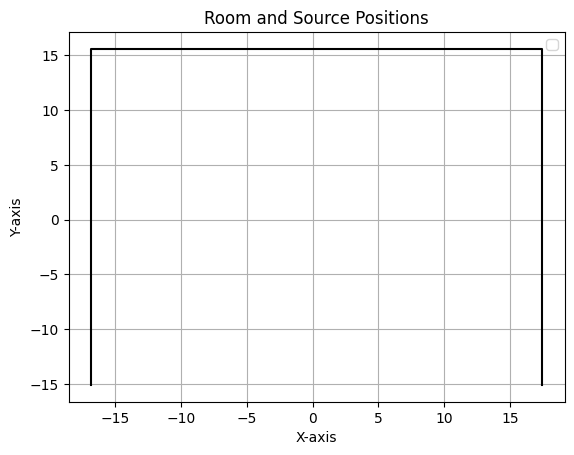

In [10]:
left_wall = np.random.uniform(low=-20, high=-15)
right_wall = np.random.uniform(low=15, high=20)
top_wall = np.random.uniform(low=15, high=20)
bottom_wall = np.random.uniform(low=-20, high=-15)
corners = np.array([[left_wall, bottom_wall], [left_wall, top_wall],
                    [right_wall, top_wall], [right_wall, bottom_wall]]).T
absorption = np.random.uniform(low=0.1, high=0.99)
room = pra.Room.from_corners(corners,
                             fs=16000,
                             max_order=10,
                             absorption=absorption)
plt.figure()
plt.plot(corners[0, :], corners[1, :], 'k-')  # Plot walls
#plt.scatter([voice_loc[0] for voice_loc in voice_positions],
               # [voice_loc[1] for voice_loc in voice_positions], color='r', marker='o', label='Voice')
plt.title('Room and Source Positions')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


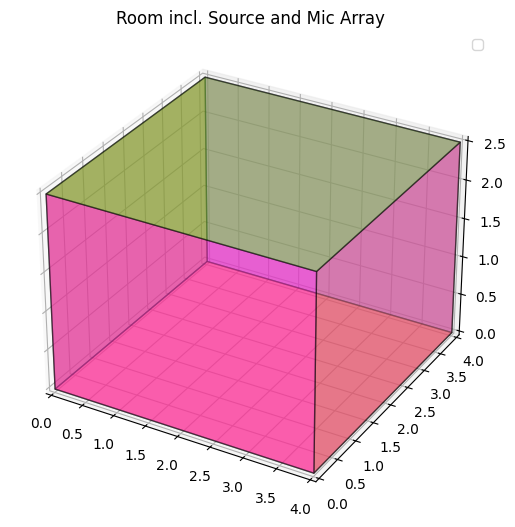

In [5]:
#Room impulse response (RIR) generation and propagation simulation
# specify signal source
room_dimensions = [4, 4, 2.5]  # Length, Width, Height in meters
fs, signal = wavfile.read("C:/Users/yosra/Documents/AV-speech-separation/Datasets/Grid Corpus/audio_25k/s1/bbaf2n.wav")
materials=pra.Material(0.5, 0.15)
shoebox =simulate_room_with_reverberation(fs,
                                     shoebox=True, 
                                     room_dimensions=room_dimensions, 
                                     room_corners=None, 
                                     absorption_coefficient=0.7,
                                     max_order = 1,
                                     materials = materials,
                                     ray_tracing=True, 
                                     air_absorption=True)

# Set the ray tracing parameters
shoebox.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
plot_room(shoebox)

Room dimensions array shape: [4. 4.]
Room dimensions array: [4.  4.  2.5]


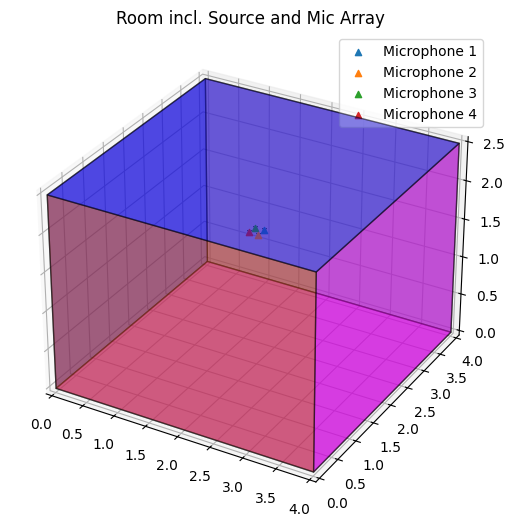

In [6]:
# Height of a person (170 cm)
person_height = 1.7
center_x, center_y = room_dimensions[0]/2, room_dimensions[1]/2

# Distance from the center to each microphone (assume glasses width of 20 cm)
glasses_width = 0.139
mic_array = np.array([
    [center_x + glasses_width/2, center_y + glasses_width/2, person_height],
    [center_x + glasses_width/2, center_y - glasses_width/2, person_height],
    [center_x - glasses_width/2, center_y + glasses_width/2, person_height],
    [center_x - glasses_width/2, center_y - glasses_width/2, person_height]
])

# Calculate microphone positions
mic_positions = mic_array
add_microphone_array(shoebox, mic_positions, array_layout='custom', num_mics=4, mic_spacing=0.1)
plot_room(shoebox, mic_coordinates=mic_positions, xlim=room_dimensions[0], ylim=room_dimensions[1], zlim=room_dimensions[2])

Speaker Position: X = 2.7071067811865475, Y = 1.2928932188134525, Z = 1.8


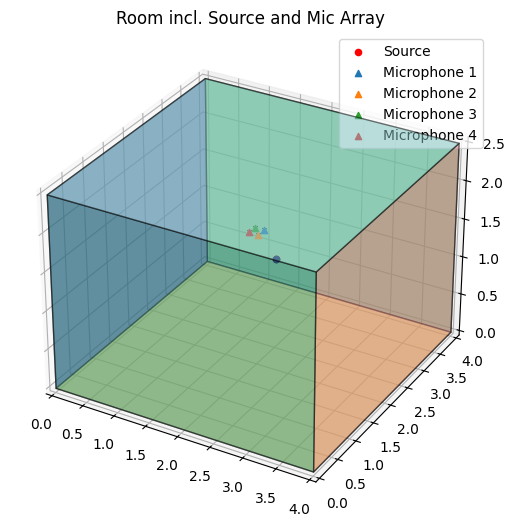

In [9]:
# Speaker information
speaker_height = 1.8
speaker_position = [center_x + math.sqrt(2)/2, center_y - math.sqrt(2)/2, speaker_height]
print(f"Speaker Position: X = {speaker_position[0]}, Y = {speaker_position[1]}, Z = {speaker_position[2]}")
# Adding source
add_sound_source(shoebox, speaker_position)
plot_room(shoebox, 
          source_coordinates= speaker_position, 
          mic_coordinates=mic_positions,
          xlim=room_dimensions[0], ylim=room_dimensions[1], zlim=room_dimensions[2])

In [ ]:
#Room impulse response (RIR) generation and propagation simulation
# specify signal source
room_dimensions = [4, 4, 2.5]  # Length, Width, Height in meters
fs, signal = wavfile.read("C:/Users/yosra/Documents/AV-speech-separation/Datasets/Grid Corpus/audio_25k/s1/bbaf2n.wav")

# set max_order to a low value for a quick (but less accurate) RIR
shoebox = pra.ShoeBox(room_dimensions, fs=fs, max_order=1, materials=pra.Material(0.5, 0.15), ray_tracing=True, air_absorption=True)

# Set the ray tracing parameters
shoebox.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
# Height of a person (170 cm)
person_height = 1.7
center_x, center_y = room_dimensions[0]/2, room_dimensions[1]/2

# Distance from the center to each microphone (assume glasses width of 20 cm)
glasses_width = 0.139
mic_array = np.array([
    [center_x + glasses_width/2, center_y + glasses_width/2, person_height],
    [center_x + glasses_width/2, center_y - glasses_width/2, person_height],
    [center_x - glasses_width/2, center_y + glasses_width/2, person_height],
    [center_x - glasses_width/2, center_y - glasses_width/2, person_height]
])

# Print information about room dimensions
print("Room dimensions array shape:", np.array(room_dimensions)[:2])
print("Room dimensions array:", np.array(room_dimensions))

# Calculate microphone positions
mic_positions = mic_array

# Create a list of colors for each microphone
colors = ['r', 'g', 'b', 'c']

# Add Microphone Array to the shoebox
shoebox.add_microphone_array(pra.MicrophoneArray(mic_positions.T, shoebox.fs))

# Speaker information
speaker_height = 1.8
speaker_position = [center_x + math.sqrt(2)/2, center_y - math.sqrt(2)/2, speaker_height]
print(f"Speaker Position: X = {speaker_position[0]}, Y = {speaker_position[1]}, Z = {speaker_position[2]}")
# Adding source
shoebox.add_source(speaker_position, signal=signal)

# compute image sources
shoebox.image_source_model()
plot_room(shoebox, speaker_position, mic_positions, room_dimensions[0], room_dimensions[1], room_dimensions[2])
# visualize 3D polyhedron room and image sources
fig, ax = shoebox.plot(img_order=3)
ax.set_xlim([-0.1, 4.1])
ax.set_ylim([-0.1, 4.1])
ax.set_zlim([0, 2.7]);
ax.set_title("Room with Microphones and Speaker")


In [ ]:
# plotting RIR
shoebox.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [ ]:
#Measure reverberation time 
t60 = pra.experimental.measure_rt60(shoebox.rir[0][0], fs=shoebox.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

In [ ]:
#Simulate the signal 
shoebox.simulate()
print(shoebox.mic_array.signals.shape)
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)


In [ ]:
print("Simulated propagation to first mic:")
IPython.display.Audio(shoebox.mic_array.signals[0,:], rate=fs)